# 01 Introduction

Active Subspaces (AS) proposed by Trent Russi and developed by Paul Constantine is a technique for dimension reduction in parameter space. In brief AS are defined as the leading eigenspaces of the correlation matrix of the model function's gradient (for scalar model functions) and constitutes a global sensitivity index.

In the context of ridge approximation, the choice of the active subspace corresponds to the minimizer of an upper bound of the mean square error obtained through Poincarè-type inequalities.

After performing dimension reduction in the parameter space through AS, the method can be applied to reduce the computational costs of different parameter studies such as inverse problems, optimization tasks and numerical itnergation. 

The main reference for this topic is [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies](https://doi.org/10.1137/1.9781611973860)

### The quantities related to the input space are:
1. $m\in\mathbb{N}$ the dimension of the input space,
2. $(\Omega, \mathcal{F}, P)$ the probability space,
3. $\mathbf{X}:(\Omega, \mathcal{F},P)\rightarrow \mathbb{R}^m$, the absolutely continuous random vector representing the parameters,
4. $\rho:\mathbb{R}^{m}\rightarrow \mathbb{R}$, the probability density of $\mathbf{X}$ with support $\mathcal{X}\subset\mathbb{R}^{m}$.

### The quantities related to the output are:
1. $f:\mathcal{X}\subset\mathbb{R}^{m}\rightarrow \mathbb{R}$, the quantity of interest,
2. $\nabla f:\mathcal{X}\subset\mathbb{R}^{m}\rightarrow \mathbb{R}^{m}$, the gradients of $f$.

### Reduction with Active Subspaces
The correlation matrix of the gradients of $f$ is approximated with the Monte Carlo method. The the eigendecomposition of the resulting symmetric positive definite matrix is performed

$$ \large
\mathbf{C} = \int_{\mathcal{X}} (\nabla_{\mathbf{x}} f) ( \nabla_{\mathbf{x}} f )^T
\rho \, d \mathbf{x} \approx \frac{1}{M}\sum_{i=1}^{M} (\nabla_{\mathbf{x}} f) ( \nabla_{\mathbf{x}} f )^T = \mathbf{W} \mathbf{\Lambda} \mathbf{W}^T
$$

The Active and Inactive subspaces decompose the original domain in a direct product.

$$\large
\mathbf{\Lambda} =   \begin{bmatrix} \mathbf{\Lambda}_1 & \\
                                     &
                                     \mathbf{\Lambda}_2\end{bmatrix},
\qquad
\mathbf{W} = \left [ \mathbf{W}_1 \quad \mathbf{W}_2 \right ],
\qquad
\mathbf{W}_1 \in \mathbb{R}^{m\times r}
\qquad
\mathbf{W}_2 \in \mathbb{R}^{m\times m-r}
$$

where $r$ is the dimension of the Active Subspace and $\mathbf{\Lambda}$ is the diagonal matrix of decreasingly ordered eigenvalues $\lambda_{1},\dots,\lambda_{m}$. Then the input data can be decomposed as

$$\large
\mathbf{x} = \mathbf{W}\mathbf{W}^T\mathbf{x} =
\mathbf{W}_1\mathbf{W}_1^T\mathbf{x} +
\mathbf{W}_2\mathbf{W}_2^T\mathbf{x} = \mathbf{W}_1 \mathbf{y} +
\mathbf{W}_2 \mathbf{z}.
$$

### Choice of the dimension of the Active Subspace

The dimension of the reduced parameter space can be chosen a priori for a specific parameter study (for example r-dimensional regression), it can be chosen in order to satisfy an optimal a priori ridge approximation error for a given tolerance $\epsilon$ (residual energy minimization)

$$\large
\mathbb{E}_{\rho}\left[\lVert f(\mathbf{X})-\mathbb{E}_{\rho}[f|\mathbf{W}_{1}\mathbf{X}]\rVert^{2}_{2}\right]\leq\sum_{i=r+1}^{m}\lambda_{i}\leq\epsilon^{2}
$$

or it is determined to guarantee a good accuracy of the numerical method used to evaluate it (searching for the highest spectral gap $\lambda_{r}-\lambda_{r+1}$)

$$\large
\text{dist}(\text{ran}(\mathbf{W}_{1}),\text{ran}(\hat{\mathbf{W}}_{1}))\leq\frac{4\lambda_{1}\omega}{\lambda_{r}-\lambda_{r+1}}
$$

where $\omega\in(0,(\lambda_{r}-\lambda_{r+1})/5\lambda_{1}]$ is a bound on the relative error of the discretization of the correlation matrix C with Monte Carlo, $\hat{\mathbf{W}}_{1}$ is the approximated Active Subspace projection matrix due to Monte Carlo and $\text{ran}(W)$ represents the range of the matrix $W$. The last inequivalence is valid if the number of samples is high enough.

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad as egrad
from scipy import linalg
import matplotlib.pyplot as plt
from functools import partial

from athena.active import ActiveSubspaces
from athena.utils import Normalizer

%matplotlib notebook

Set the number of samples used for Monte Carlo (M$\rightarrow$n_samples) and the dimension of the input space (m$\rightarrow$input_dim)

In [2]:
np.random.seed(42)

# Global parameters
n_samples = 400
input_dim = 2

Choose the distribution of the inputs. In general not all probability distribution satisfy the a priori bound on the root mean square error

$$
\mathbb{E}_{\rho}\left[\lVert f(\mathbf{X})-\mathbb{E}_{\rho}[f|\mathbf{W}_{1}\mathbf{X}]\rVert^{2}_{2}\right]\leq\sum_{i=r+1}^{m}\lambda_{i}\leq\epsilon^{2}
$$

In [10]:
# Uniformly distributed inputs
lb = 0 * np.ones(input_dim) # lower bounds
ub = 2 * np.ones(input_dim) # upper bounds

def inputs_uniform(n_samples, lb,  ub):
    return np.vstack(
        np.array([np.random.uniform(lb[i], ub[i], n_samples) for i in range(lb.shape[0])]).T)

In [5]:
# Gaussian model for the inputs
mean = np.ones(input_dim)
cov = 0.5*np.diag(np.ones(input_dim))

def inputs_gaussian(n_samples, mean, cov):
    return np.random.multivariate_normal(mean, cov, n_samples)


The function of interest is sin_2d defined in the directory data. Also a radial symmetric function with generatrix $\sin(x^{2})$ are available. Different generatrices can be chosen modifying the function generatrix.

In [6]:
# custom 2d outputs of interest
from data.numpy_functions import cubic_2d, sin_2d, exp_2d

# Radial symmetric output of interest
def generatrix(x):
    return np.sin(x)

def output(x, normalizer, r):
    if normalizer:
        return r(np.linalg.norm(normalizer.inverse_transform(x), axis=1)**2)
    else:
        return r(np.linalg.norm(x, axis=1)**2)


Sample the inputs with numpy.random and normalize them. Uniform distributions can be normalized with Normalizer class from athena library, providing the lower and upper bounds.

In [7]:
# Generate and normalize inputs

#x_raw = inputs_uniform(n_samples, lb, ub)
#nor = Normalizer(lb, ub)
#x = nor.fit_transform(x_raw)

x_raw = inputs_gaussian(n_samples, mean, cov)
x = (x_raw-mean).dot(linalg.sqrtm(np.linalg.inv(cov)))


Evaluate the outputs and the gradients w.r.t the inputs previously sampled.

<IPython.core.display.Javascript object>


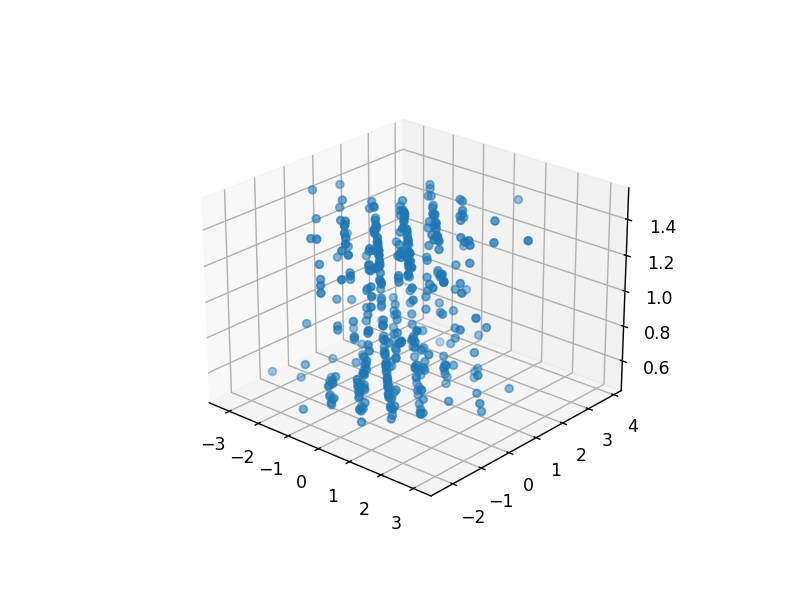

In [8]:
# Define the output of interest and compute the gradients

# func = partial(output, normalizer=nor, r=generatrix)
func = sin_2d
f = func(x)
df = egrad(func)(x)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1], f)

It can be seen that sin_2d is constant on the affine subspaces $x_{1}+x_{2}=const$. Since the average variance of the gradients of the model lies on the subspace spanned by the vector $(1,1)$ we suspect the presence of a one-dimensional active subspace. Mind that in general the active subspace should be thought as a set of directions (a summary statistics) rather than a subspace of the inputs space.

Eigenvalues: [9.78728699e+00 1.09237082e-31]


<IPython.core.display.Javascript object>


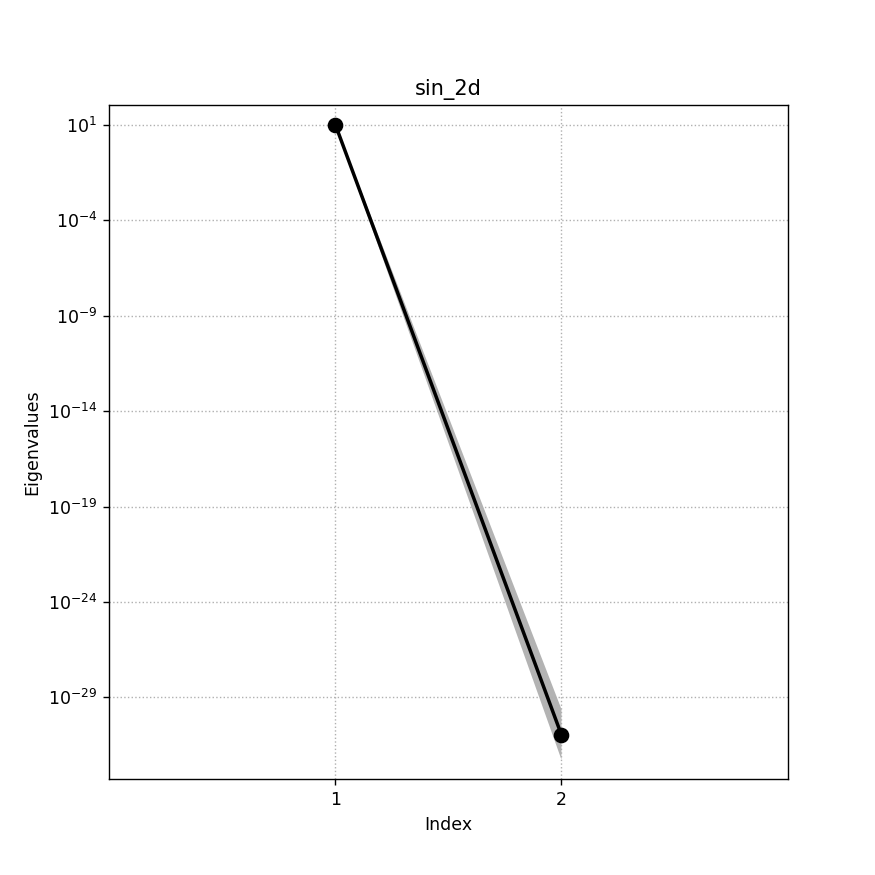

In [9]:
# compute the active subspace
asub = ActiveSubspaces()
asub.compute(gradients=df, method='exact')

# set the dimension of the active subspace
asub.partition(1)

title = 'sin_2d'
asub.plot_eigenvalues(figsize=(7, 7), title=title)
print("Eigenvalues: {}".format(np.squeeze(asub.evals)))

As guessed previously the active subspace is spanned by the vector $(1,1)$ normalized.

<IPython.core.display.Javascript object>


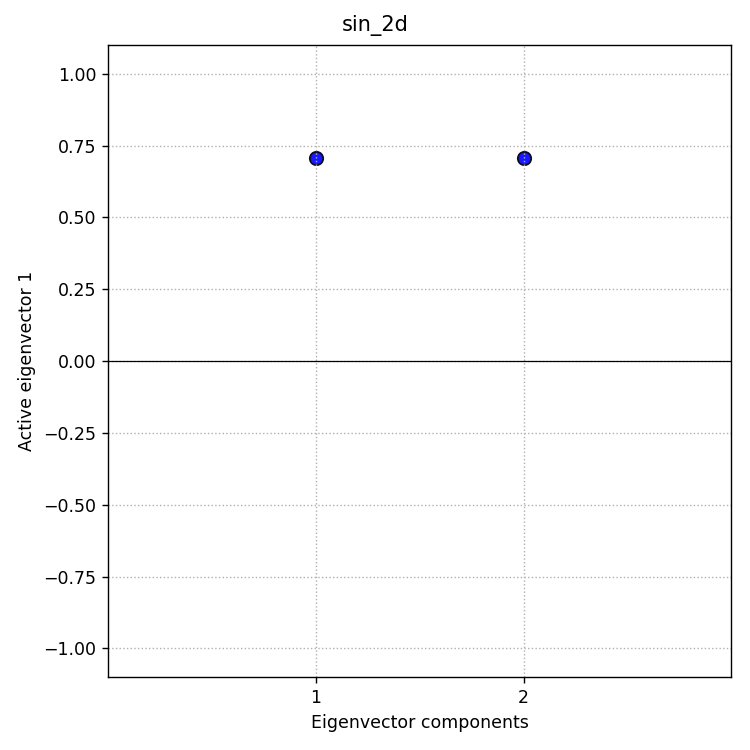

In [9]:
asub.plot_eigenvectors(figsize=(6, 6), title=title)

<IPython.core.display.Javascript object>


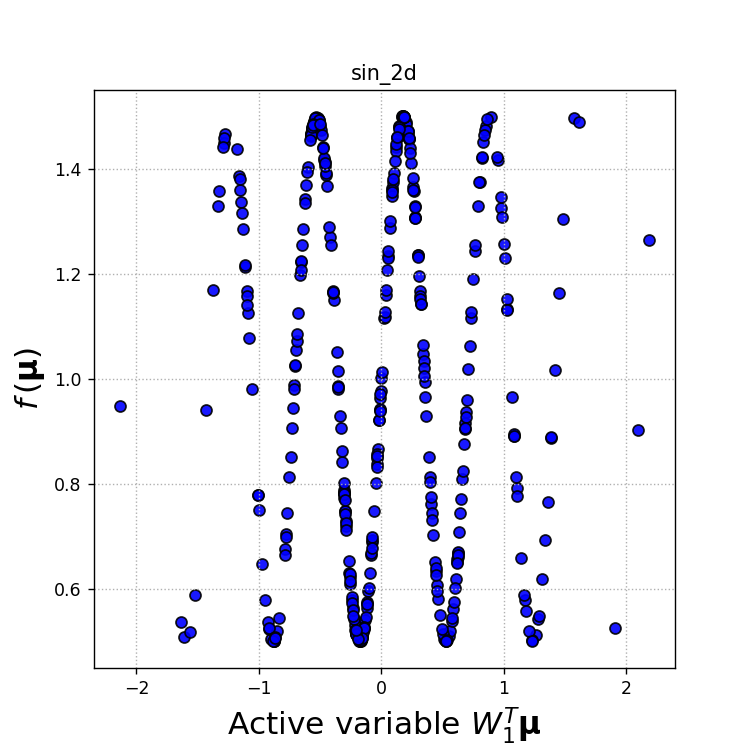

In [10]:
asub.plot_sufficient_summary(x, f, figsize=(6, 6), title=title)

<IPython.core.display.Javascript object>


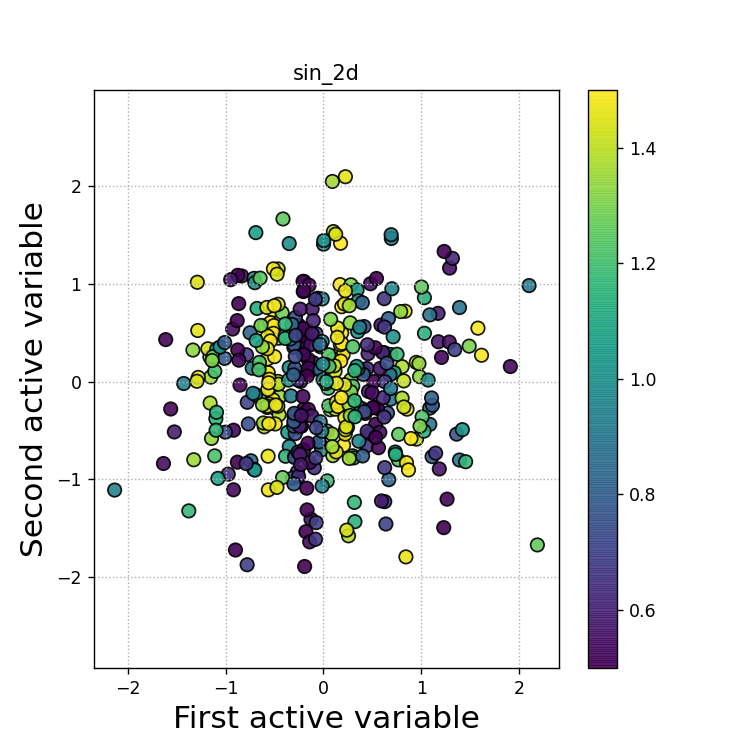

In [11]:
asub.partition(2)
asub.plot_sufficient_summary(x, f, figsize=(6, 6), title=title)

### Remarks

Try different models from data.numpy_functions, change input_dim, n_samples, change input distributions between uniform and Gaussian, change the domain.